XGBoost_RGBW_train

In [ ]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # <-- Make sure this is properly aligned
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tqdm import tqdm


# ------------------- JSON Helper -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extractors -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

# ------------------- Feature Aggregation -------------------
def extract_combined_features(root_folder, coco_json_path):
    image_types = ["r_", "g_", "b_", "w_"]
    categories = ["n_ovary", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):  # 13 texture + 6 shape per image type
                    all_features.append(feat_list)
                    all_labels.append(cat)

    return all_features, all_labels

from xgboost import XGBClassifier
import joblib  # <-- Add this import at the top

def train_with_xgboost(features, labels, title="Multichannel RGBW", model_save_dir="xgboost_model"):
    print(f"📊 {title} | Encoding + Scaling + SMOTE...")

    le = LabelEncoder()
    y = le.fit_transform(labels)

    scaler = MinMaxScaler()
    X = scaler.fit_transform(features)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"🔢 After SMOTE: {np.bincount(y_resampled)}")

    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    preds_all, truths_all = [], []

    clf = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=3,
                        random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    
    for train_idx, test_idx in rkf.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
        y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        preds_all.extend(preds)
        truths_all.extend(y_test)

    print(f"\n✅ Final Classification Report ({title} - XGBoost):")
    print(classification_report(truths_all, preds_all, target_names=le.classes_))

    ConfusionMatrixDisplay.from_predictions(
        truths_all, preds_all, display_labels=le.classes_, cmap='Blues'
    )
    plt.title(f"{title} Confusion Matrix (XGBoost)")
    plt.tight_layout()
    plt.show()

    # Feature importance plot
    plt.figure(figsize=(10, 6))
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = [f"F{i}" for i in range(X.shape[1])]
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Feature Importance")
    plt.title(f"{title} Feature Importances (XGBoost)")
    plt.tight_layout()
    plt.show()

    # 🔒 Save model, scaler, and label encoder
    os.makedirs(model_save_dir, exist_ok=True)
    joblib.dump(clf, os.path.join(model_save_dir, "xgboost_model.pkl"))
    joblib.dump(scaler, os.path.join(model_save_dir, "scaler.pkl"))
    joblib.dump(le, os.path.join(model_save_dir, "label_encoder.pkl"))
    print(f"\n💾 Model, scaler, and label encoder saved to: {model_save_dir}")


if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\ML_MSI\ROI_based\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\\Granulosa_data_1\\vipul_annotation_1\\annotation_27_05_25_vipul_3.json"
    MODEL_SAVE_DIR = r"H:\\ML_MSI\\ROI_based\\XGB_model"

    print("🔍 Extracting unified RGBW features...")
    X_all, y_all = extract_combined_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)

    if not X_all:
        print("❌ No features found for RGBW.")
    else:
        train_with_xgboost(X_all, y_all, title="Multichannel RGBW", model_save_dir=MODEL_SAVE_DIR)


XGBoost_Val_RGBW

In [ ]:
import os
import json
import numpy as np
import joblib
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ------------------- JSON Helpers -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extraction -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

def extract_combined_features(root_folder, coco_json_path):
    image_types = ["r_", "g_", "b_", "w_"]
    categories = ["n_ovary", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):
                    all_features.append(feat_list)
                    all_labels.append(cat)

    return all_features, all_labels

# ------------------- Load + Validate -------------------
def load_assets(model_dir):
    clf = joblib.load(os.path.join(model_dir, "xgboost_model.pkl"))
    scaler = joblib.load(os.path.join(model_dir, "scaler.pkl"))
    label_encoder = joblib.load(os.path.join(model_dir, "label_encoder.pkl"))
    return clf, scaler, label_encoder

def validate_xgboost_model(X_val, y_val, model_dir):
    clf, scaler, label_encoder = load_assets(model_dir)
    y_true = label_encoder.transform(y_val)
    X_scaled = scaler.transform(X_val)

    y_pred = clf.predict(X_scaled)

    print("✅ Validation Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=label_encoder.classes_, cmap='Blues'
    )
    plt.title("XGBoost Validation Confusion Matrix")
    plt.tight_layout()
    plt.show()

# ------------------- Main -------------------
if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\ML_MSI\ROI_based\val_data"
    COCO_JSON_PATH = r"H:\ML_MSI\ROI_based\val_data\annotation_27_05_25_vipul_3.json"
    MODEL_DIR = r"H:\ML_MSI\ROI_based\XGB_model"

    print("🔍 Extracting validation features...")
    X_val, y_val = extract_combined_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)

    if not X_val:
        print("❌ No features extracted.")
    else:
        validate_xgboost_model(X_val, y_val, model_dir=MODEL_DIR)


🔍 Extracting unified RGBW features...
📊 Multichannel RGBW | Encoding + Scaling + SMOTE...
🔢 After SMOTE: [27 27 27]


c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:16:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:16:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:16:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Final Classification Report (Multichannel RGBW - XGBoost):
              precision    recall  f1-score   support

        h_nc       0.72      0.72      0.72        81
     n_ovary       0.69      0.62      0.65        81
      tumour       0.72      0.80      0.76        81

    accuracy                           0.71       243
   macro avg       0.71      0.71      0.71       243
weighted avg       0.71      0.71      0.71       243



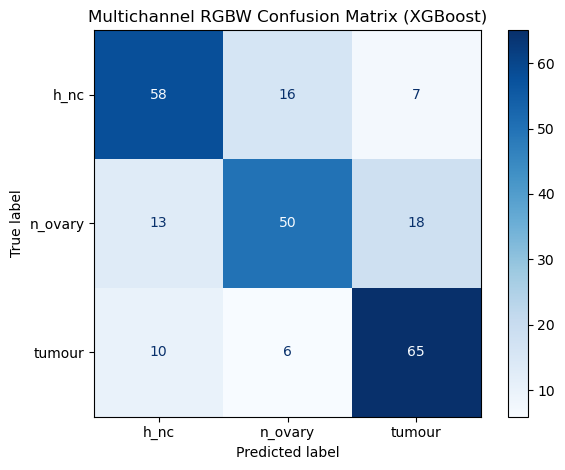

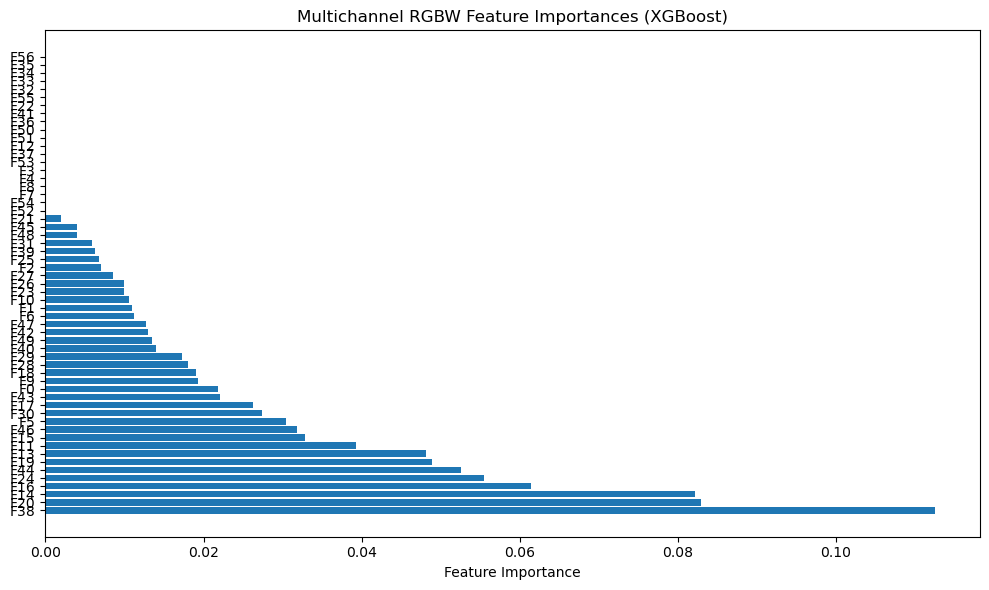


💾 Model, scaler, and label encoder saved to: H:\\ML_MSI\\ROI_based\\XGB_RGB


In [1]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # <-- Make sure this is properly aligned
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tqdm import tqdm


# ------------------- JSON Helper -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extractors -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

# ------------------- Feature Aggregation -------------------
def extract_combined_features(root_folder, coco_json_path):
    image_types = ["r_", "g_", "b_"]
    categories = ["n_ovary", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):  # 13 texture + 6 shape per image type
                    all_features.append(feat_list)
                    all_labels.append(cat)

    return all_features, all_labels

from xgboost import XGBClassifier
import joblib  # <-- Add this import at the top

def train_with_xgboost(features, labels, title="Multichannel RGBW", model_save_dir="xgboost_model"):
    print(f"📊 {title} | Encoding + Scaling + SMOTE...")

    le = LabelEncoder()
    y = le.fit_transform(labels)

    scaler = MinMaxScaler()
    X = scaler.fit_transform(features)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"🔢 After SMOTE: {np.bincount(y_resampled)}")

    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    preds_all, truths_all = [], []

    clf = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=3,
                        random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    
    for train_idx, test_idx in rkf.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
        y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        preds_all.extend(preds)
        truths_all.extend(y_test)

    print(f"\n✅ Final Classification Report ({title} - XGBoost):")
    print(classification_report(truths_all, preds_all, target_names=le.classes_))

    ConfusionMatrixDisplay.from_predictions(
        truths_all, preds_all, display_labels=le.classes_, cmap='Blues'
    )
    plt.title(f"{title} Confusion Matrix (XGBoost)")
    plt.tight_layout()
    plt.show()

    # Feature importance plot
    plt.figure(figsize=(10, 6))
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = [f"F{i}" for i in range(X.shape[1])]
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Feature Importance")
    plt.title(f"{title} Feature Importances (XGBoost)")
    plt.tight_layout()
    plt.show()

    # 🔒 Save model, scaler, and label encoder
    os.makedirs(model_save_dir, exist_ok=True)
    joblib.dump(clf, os.path.join(model_save_dir, "xgboost_model.pkl"))
    joblib.dump(scaler, os.path.join(model_save_dir, "scaler.pkl"))
    joblib.dump(le, os.path.join(model_save_dir, "label_encoder.pkl"))
    print(f"\n💾 Model, scaler, and label encoder saved to: {model_save_dir}")


if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\ML_MSI\ROI_based\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\\Granulosa_data_1\\vipul_annotation_1\\annotation_27_05_25_vipul_3.json"
    MODEL_SAVE_DIR = r"H:\\ML_MSI\\ROI_based\\XGB_RGB"

    print("🔍 Extracting unified RGBW features...")
    X_all, y_all = extract_combined_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)

    if not X_all:
        print("❌ No features found for RGBW.")
    else:
        train_with_xgboost(X_all, y_all, title="Multichannel RGBW", model_save_dir=MODEL_SAVE_DIR)


🔍 Extracting validation features...
✅ Validation Classification Report:
              precision    recall  f1-score   support

        h_nc       0.83      0.71      0.77         7
     n_ovary       0.75      0.50      0.60         6
      tumour       0.50      1.00      0.67         3

    accuracy                           0.69        16
   macro avg       0.69      0.74      0.68        16
weighted avg       0.74      0.69      0.69        16



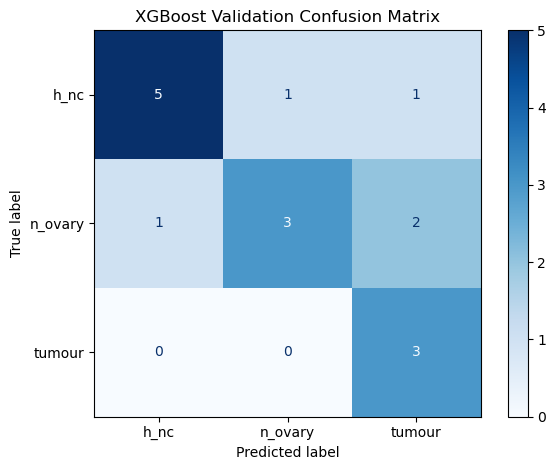

In [2]:
import os
import json
import numpy as np
import joblib
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ------------------- JSON Helpers -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extraction -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

def extract_combined_features(root_folder, coco_json_path):
    image_types = ["r_", "g_", "b_"]
    categories = ["n_ovary", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):
                    all_features.append(feat_list)
                    all_labels.append(cat)

    return all_features, all_labels

# ------------------- Load + Validate -------------------
def load_assets(model_dir):
    clf = joblib.load(os.path.join(model_dir, "xgboost_model.pkl"))
    scaler = joblib.load(os.path.join(model_dir, "scaler.pkl"))
    label_encoder = joblib.load(os.path.join(model_dir, "label_encoder.pkl"))
    return clf, scaler, label_encoder

def validate_xgboost_model(X_val, y_val, model_dir):
    clf, scaler, label_encoder = load_assets(model_dir)
    y_true = label_encoder.transform(y_val)
    X_scaled = scaler.transform(X_val)

    y_pred = clf.predict(X_scaled)

    print("✅ Validation Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=label_encoder.classes_, cmap='Blues'
    )
    plt.title("XGBoost Validation Confusion Matrix")
    plt.tight_layout()
    plt.show()

# ------------------- Main -------------------
if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\ML_MSI\ROI_based\val_data"
    COCO_JSON_PATH = r"H:\ML_MSI\ROI_based\val_data\annotation_27_05_25_vipul_3.json"
    MODEL_DIR = r"H:\ML_MSI\ROI_based\XGB_RGB"

    print("🔍 Extracting validation features...")
    X_val, y_val = extract_combined_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)

    if not X_val:
        print("❌ No features extracted.")
    else:
        validate_xgboost_model(X_val, y_val, model_dir=MODEL_DIR)


XG_ for W only

🔍 Extracting unified RGBW features...
📊 Multichannel RGBW | Encoding + Scaling + SMOTE...
🔢 After SMOTE: [27 27 27]


c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:34:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:34:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:34:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:34:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr


✅ Final Classification Report (Multichannel RGBW - XGBoost):
              precision    recall  f1-score   support

        h_nc       0.77      0.79      0.78        81
     n_ovary       0.61      0.52      0.56        81
      tumour       0.75      0.84      0.79        81

    accuracy                           0.72       243
   macro avg       0.71      0.72      0.71       243
weighted avg       0.71      0.72      0.71       243



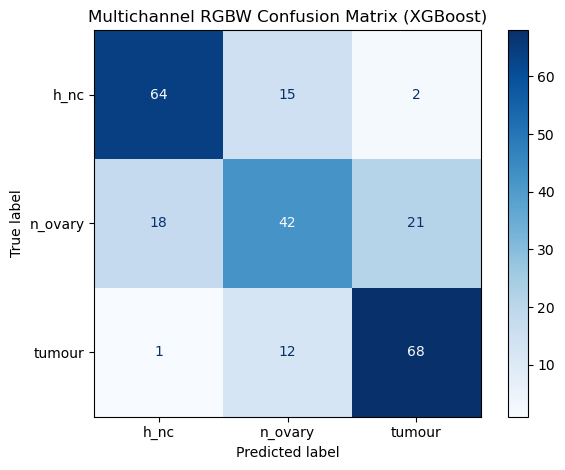

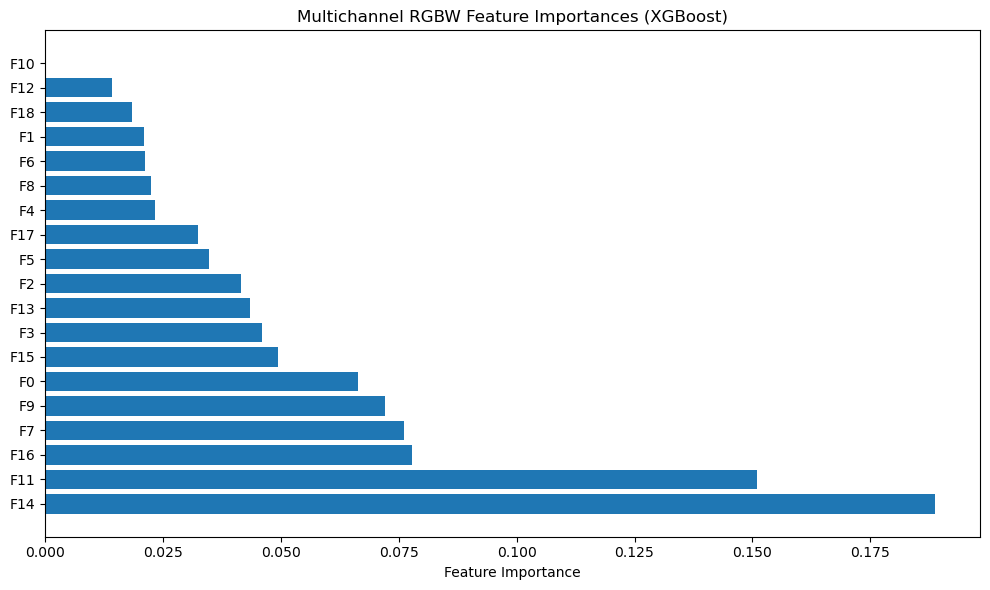


💾 Model, scaler, and label encoder saved to: H:\\ML_MSI\\ROI_based\\XGB_W


In [3]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # <-- Make sure this is properly aligned
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tqdm import tqdm


# ------------------- JSON Helper -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extractors -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

# ------------------- Feature Aggregation -------------------
def extract_combined_features(root_folder, coco_json_path):
    image_types = ["w_"]
    categories = ["n_ovary", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):  # 13 texture + 6 shape per image type
                    all_features.append(feat_list)
                    all_labels.append(cat)

    return all_features, all_labels

from xgboost import XGBClassifier
import joblib  # <-- Add this import at the top

def train_with_xgboost(features, labels, title="Multichannel RGBW", model_save_dir="xgboost_model"):
    print(f"📊 {title} | Encoding + Scaling + SMOTE...")

    le = LabelEncoder()
    y = le.fit_transform(labels)

    scaler = MinMaxScaler()
    X = scaler.fit_transform(features)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"🔢 After SMOTE: {np.bincount(y_resampled)}")

    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    preds_all, truths_all = [], []

    clf = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=3,
                        random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    
    for train_idx, test_idx in rkf.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
        y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        preds_all.extend(preds)
        truths_all.extend(y_test)

    print(f"\n✅ Final Classification Report ({title} - XGBoost):")
    print(classification_report(truths_all, preds_all, target_names=le.classes_))

    ConfusionMatrixDisplay.from_predictions(
        truths_all, preds_all, display_labels=le.classes_, cmap='Blues'
    )
    plt.title(f"{title} Confusion Matrix (XGBoost)")
    plt.tight_layout()
    plt.show()

    # Feature importance plot
    plt.figure(figsize=(10, 6))
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = [f"F{i}" for i in range(X.shape[1])]
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Feature Importance")
    plt.title(f"{title} Feature Importances (XGBoost)")
    plt.tight_layout()
    plt.show()

    # 🔒 Save model, scaler, and label encoder
    os.makedirs(model_save_dir, exist_ok=True)
    joblib.dump(clf, os.path.join(model_save_dir, "xgboost_model.pkl"))
    joblib.dump(scaler, os.path.join(model_save_dir, "scaler.pkl"))
    joblib.dump(le, os.path.join(model_save_dir, "label_encoder.pkl"))
    print(f"\n💾 Model, scaler, and label encoder saved to: {model_save_dir}")


if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\ML_MSI\ROI_based\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\\Granulosa_data_1\\vipul_annotation_1\\annotation_27_05_25_vipul_3.json"
    MODEL_SAVE_DIR = r"H:\\ML_MSI\\ROI_based\\XGB_W"

    print("🔍 Extracting unified RGBW features...")
    X_all, y_all = extract_combined_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)

    if not X_all:
        print("❌ No features found for RGBW.")
    else:
        train_with_xgboost(X_all, y_all, title="Multichannel RGBW", model_save_dir=MODEL_SAVE_DIR)


validation_XG_w

🔍 Extracting validation features...
✅ Validation Classification Report:
              precision    recall  f1-score   support

        h_nc       1.00      0.71      0.83         7
     n_ovary       0.62      0.83      0.71         6
      tumour       0.67      0.67      0.67         3

    accuracy                           0.75        16
   macro avg       0.76      0.74      0.74        16
weighted avg       0.80      0.75      0.76        16



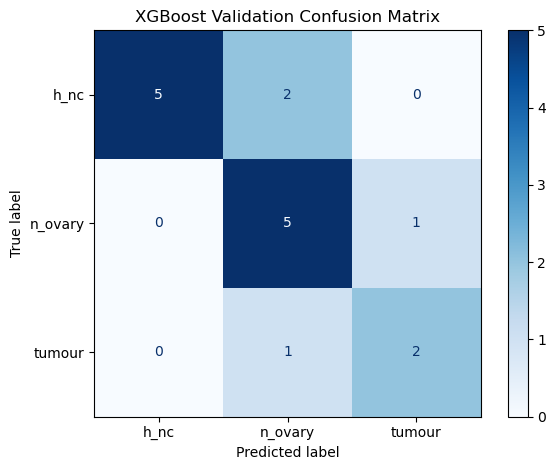

In [5]:
import os
import json
import numpy as np
import joblib
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ------------------- JSON Helpers -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extraction -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

def extract_combined_features(root_folder, coco_json_path):
    image_types = ["w_"]
    categories = ["n_ovary", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):
                    all_features.append(feat_list)
                    all_labels.append(cat)

    return all_features, all_labels

# ------------------- Load + Validate -------------------
def load_assets(model_dir):
    clf = joblib.load(os.path.join(model_dir, "xgboost_model.pkl"))
    scaler = joblib.load(os.path.join(model_dir, "scaler.pkl"))
    label_encoder = joblib.load(os.path.join(model_dir, "label_encoder.pkl"))
    return clf, scaler, label_encoder

def validate_xgboost_model(X_val, y_val, model_dir):
    clf, scaler, label_encoder = load_assets(model_dir)
    y_true = label_encoder.transform(y_val)
    X_scaled = scaler.transform(X_val)

    y_pred = clf.predict(X_scaled)

    print("✅ Validation Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=label_encoder.classes_, cmap='Blues'
    )
    plt.title("XGBoost Validation Confusion Matrix")
    plt.tight_layout()
    plt.show()

# ------------------- Main -------------------
if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\ML_MSI\ROI_based\val_data"
    COCO_JSON_PATH = r"H:\ML_MSI\ROI_based\val_data\annotation_27_05_25_vipul_3.json"
    MODEL_DIR = r"H:\ML_MSI\ROI_based\XGB_W"

    print("🔍 Extracting validation features...")
    X_val, y_val = extract_combined_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)

    if not X_val:
        print("❌ No features extracted.")
    else:
        validate_xgboost_model(X_val, y_val, model_dir=MODEL_DIR)
